# YouTube Audience Network Analysis

This notebook constructs and analyzes an audience network from YouTube comment data,
where videos are connected by shared commenters.

### Imports

In [16]:
# Auto-reload modules when they change (no kernel restart needed!)
%load_ext autoreload
%autoreload 2

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Custom helper modules
from data import data_loader
from utils import filtering, network_builder, network_analysis, visualization, data_exploration

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All modules imported successfully!")
print("✓ Auto-reload enabled - changes to .py files will be picked up automatically!")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✓ All modules imported successfully!
✓ Auto-reload enabled - changes to .py files will be picked up automatically!


# 1. Data Loading and Exploration

Load comment data and perform exploratory data analysis.

In [2]:
# Configuration
DATA_PATH = '/Users/albertfares/Desktop/4650046/youtube_comments.tsv'
N_ROWS = 10_000_000  # Load first 10M rows for faster testing (set to None for full dataset)

# Load data using helper function
chunks_df = data_loader.load_comment_data(DATA_PATH, nrows=N_ROWS, verbose=True)


Loading first 10,000,000 rows from /Users/albertfares/Desktop/4650046/youtube_comments.tsv...
Data loaded! Converting to efficient dtypes...

✓ Data loaded successfully!
  Shape: (10000000, 4)
  Memory usage: 0.55 GB
  Note: Using first 10,000,000 rows


## 1.1 Initial Data Exploration

Generate comprehensive exploratory plots showing distributions, power laws, and engagement metrics.



Generating exploratory data analysis...
INITIAL DATA OVERVIEW
Total comments:          10,000,000
Unique users:               516,930
Unique videos:            3,664,508
Sample:             10,000,000 rows

User Activity:
  Median comments/user:  2
  Mean comments/user:    19.3
  Max comments/user:     37,389

Video Popularity:
  Median comments/video: 1
  Mean comments/video:   2.7
  Max comments/video:    1,979

Engagement Metrics:
  Total likes:           38,928,312
  Total replies:         2,942,350
  Avg likes/comment:     3.89
  Avg replies/comment:   0.29


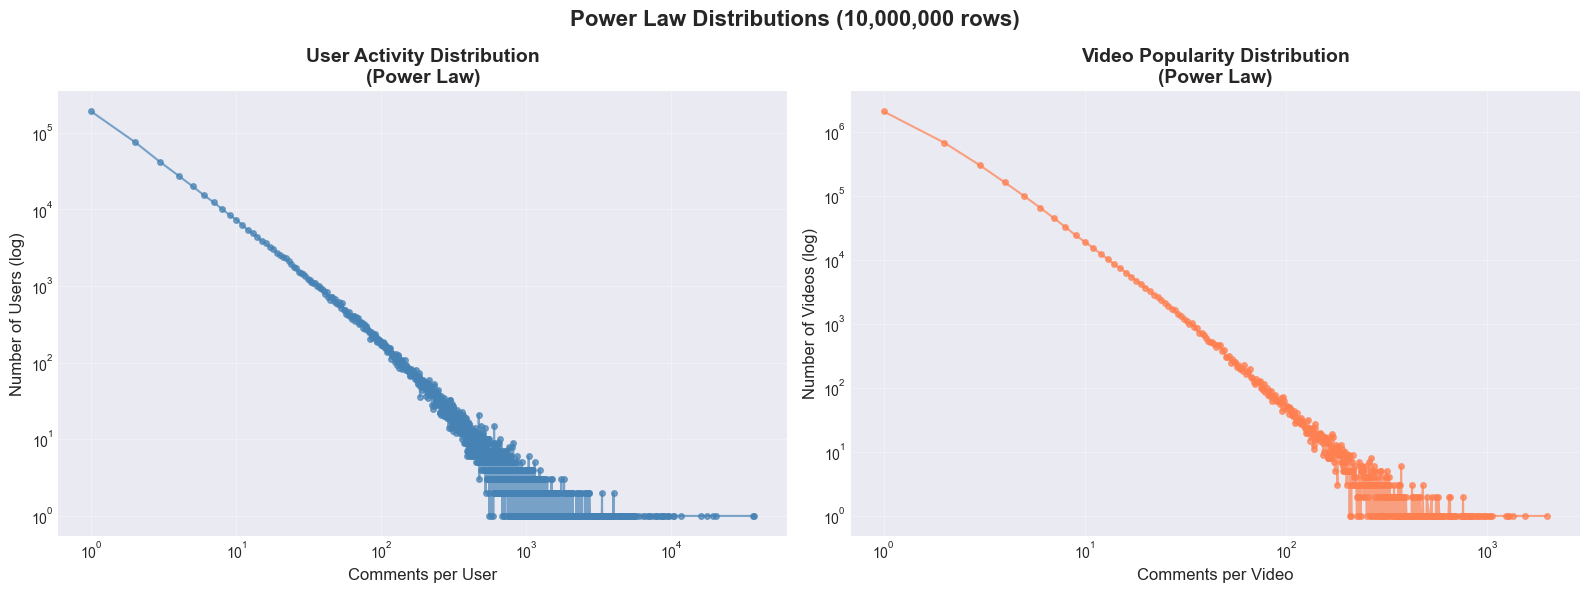

✓ Saved: data/eda_1_power_laws.png


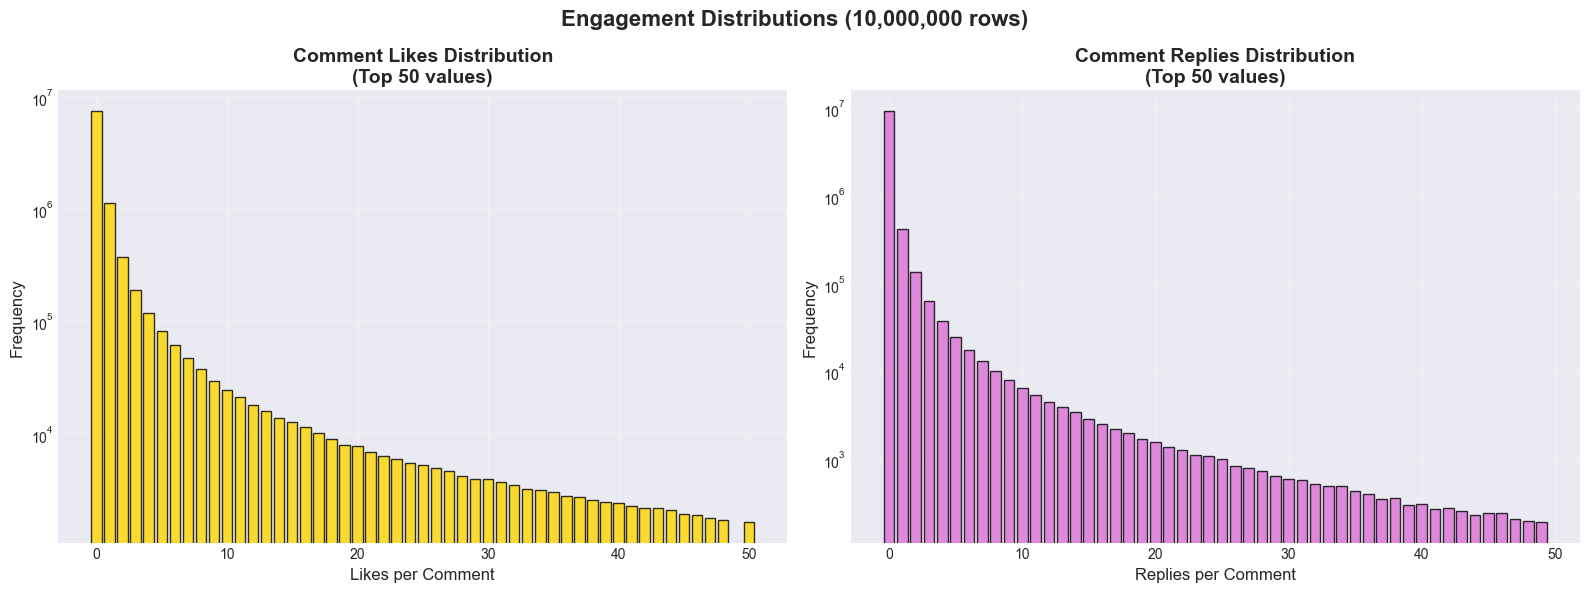

✓ Saved: data/eda_2_engagement.png


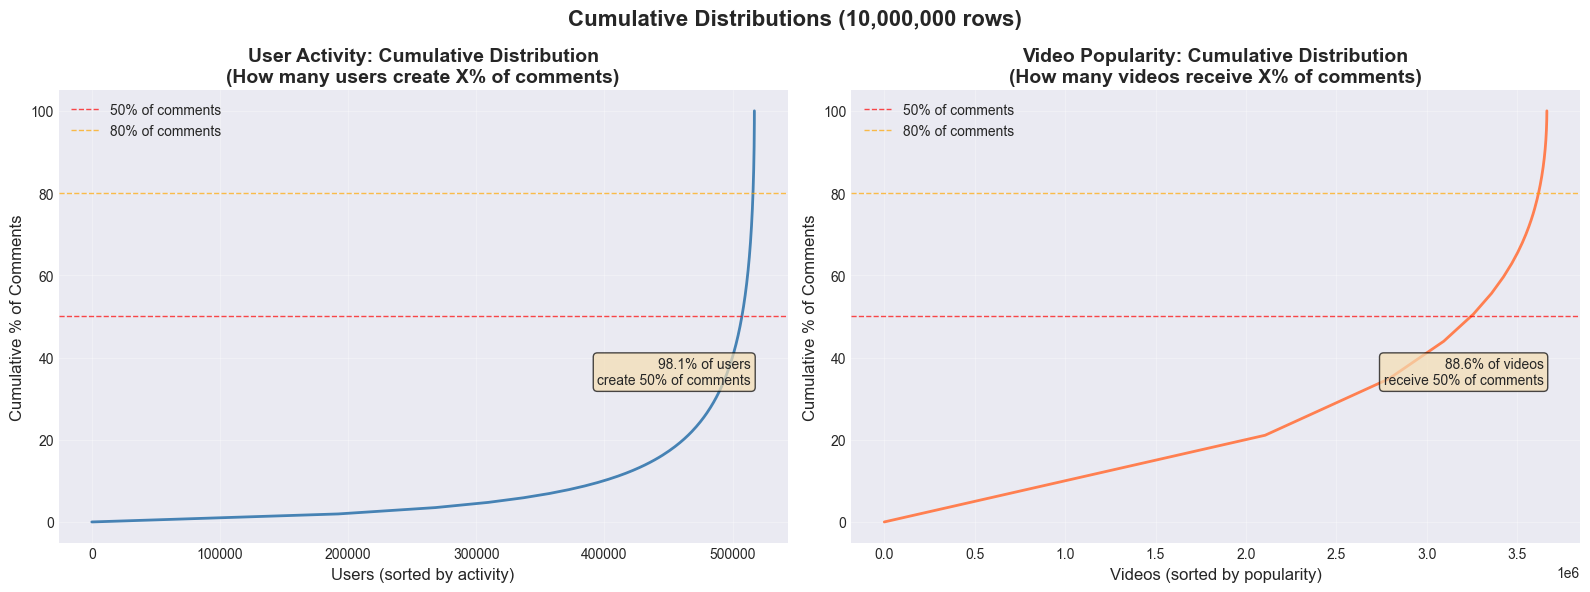

✓ Saved: data/eda_3_cumulative.png

✓ Generated 3 exploratory plots

KEY INSIGHTS
📊 Distribution: Both user activity and video popularity follow power laws
👥 Concentration: Top 98.1% of users create 50% of all comments
🎥 Concentration: Top 88.6% of videos receive 50% of all comments
💬 Engagement: 24.3% of comments have likes
💬 Engagement: 7.8% of comments have replies
🌐 Sparsity: Only 0.000528% of possible user-video pairs have comments


In [ ]:
# Comprehensive exploratory data analysis
initial_stats = data_exploration.explore_initial_data(
    chunks_df,
    output_dir='data',
    sample_name=f'{N_ROWS:,} rows',
    verbose=True
)

## 1.2 Iterative Filtering

Apply iterative filtering to focus on engaged users and popular videos:
- Keep users who commented on ≥5 distinct videos
- Keep videos with ≥10 distinct commenters

Iterates until convergence (typically 2-3 iterations).



FILTERING SUMMARY
Original size:         10,000,000
Filtered size:          1,833,908
Remaining users:           66,585
Remaining videos:          71,807
Iterations:                    10


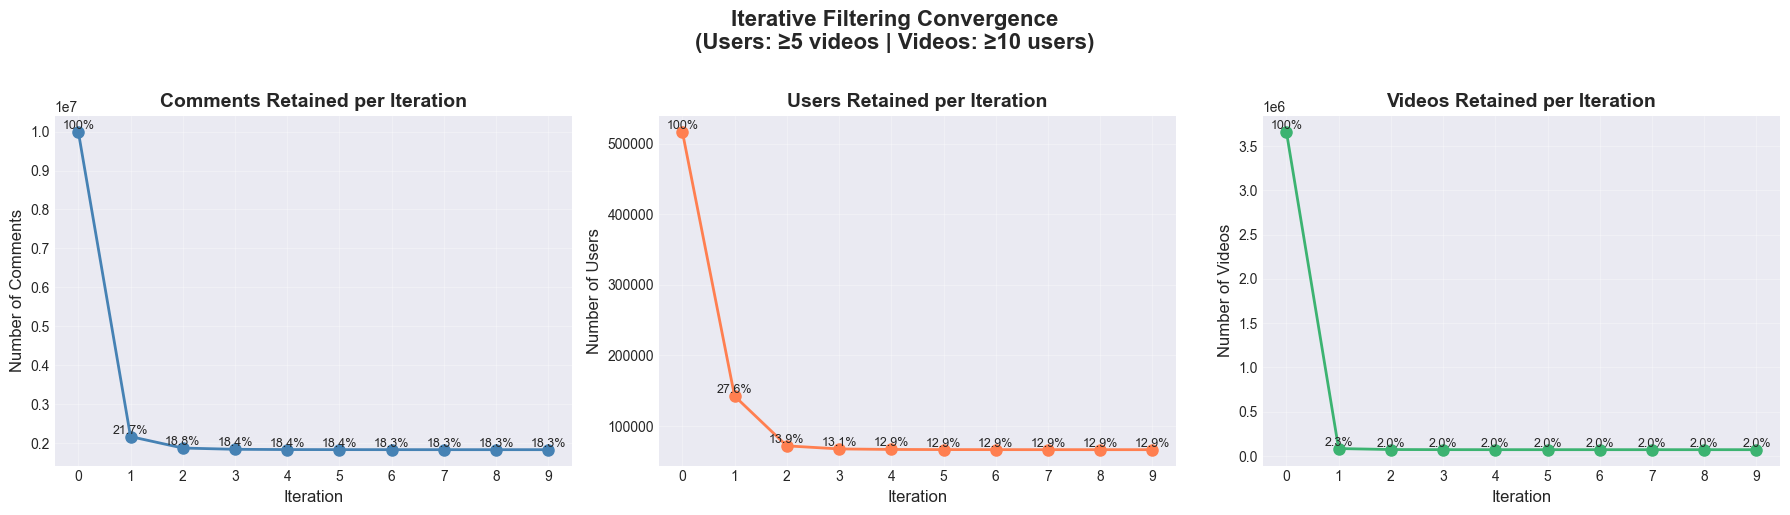

In [4]:
# Filtering parameters
MIN_VIDEOS_PER_USER = 5
MIN_USERS_PER_VIDEO = 10

# Apply iterative filtering with convergence plot
filtered_df, filter_stats = filtering.iterative_filter(
    chunks_df,
    min_videos_per_user=MIN_VIDEOS_PER_USER,
    min_users_per_video=MIN_USERS_PER_VIDEO,
    max_iterations=10,
    verbose=False,
    plot=True,
    output_dir='data'
)

# 2. Network Construction

Build the audience network where videos are nodes and edges represent shared commenters.

In [ ]:
# Network construction parameters
MIN_OVERLAP = 3        # Minimum shared commenters for an edge
MIN_JACCARD = 0.02     # Minimum Jaccard similarity: J(A,B) = |A ∩ B| / |A ∪ B|
                       # (shared commenters / total unique commenters)

# Build the network using end-to-end pipeline
G, edges_pruned, metadata = network_builder.build_audience_network(
    filtered_df,
    min_overlap=MIN_OVERLAP,
    min_jaccard=MIN_JACCARD,
    verbose=True
)

# Extract metadata for later use
video_commenter_counts = metadata['video_commenter_counts']
video_ids = metadata['video_ids']

Step 1: Preparing data...
  Input shape: (1833908, 4)
  Unique videos: 71,807
  Unique users: 66,585
  → 1,496,022 unique author-video pairs
  → 71,807 unique videos
  → 66,585 unique users

Step 2: Building video↔users mappings...
  → 71,807 videos
  → 66,585 users

Step 3: Computing video-video edges...
  Processing 66,585 users...


Building edges:   0%|          | 0/66585 [00:00<?, ?it/s]

  → Found 57,362,443 video pairs with shared commenters

Step 4: Computing edge weights...


Computing weights:   0%|          | 0/57362443 [00:00<?, ?it/s]

  → Created 57,362,443 edges

Step 5: Pruning edges...
  Before pruning: 57,362,443 edges
  After pruning:  653,942 edges
  Reduction:      98.9%

Step 6: Building NetworkX graph...
  Adding 653,942 edges...


  Building graph:   0%|          | 0/653942 [00:00<?, ?it/s]

  → Graph built: 71,807 nodes, 653,942 edges
  → Avg degree: 18.2

✓ NETWORK CONSTRUCTION COMPLETE
Videos (nodes):           71,807
Edges (pruned):          653,942
Avg degree:                 18.2


In [6]:
# Analyze network structure
network_stats = network_analysis.analyze_network_structure(G, verbose=True)


NETWORK STRUCTURE ANALYSIS

1. CONNECTIVITY:
   Total connected components: 13,840
   Largest component: 57,570 nodes (80.2%)
   2nd largest: 8 nodes
   3rd largest: 7 nodes
   Isolated nodes (size=1): 13,529

2. DEGREE DISTRIBUTION:
   Average degree: 18.21
   Median degree: 4
   Max degree: 584 (hub video)
   Nodes with degree 0: 13,529
   Nodes with degree 1: 8,752
   Nodes with degree ≥5: 35,289

3. NETWORK DENSITY:
   Density: 0.00025365 (0.025365%)
   Network is VERY SPARSE


# 3. Network Analysis

## 3.1 Betweenness Centrality

Identify "pathway" videos that act as bridges between different communities in the network.


In [7]:
# Compute betweenness centrality on largest component
betw, G_main = network_analysis.compute_betweenness_centrality(
    G, 
    k=100,          # Sample 100 nodes for approximation
    seed=42,        # For reproducibility
    verbose=True
)

# Get top pathway videos
top_pathways = network_analysis.get_top_nodes(betw, top_n=20, verbose=True)



Step 7: Computing betweenness centrality...
  Largest component: 57,570 nodes
  Computing with k=100 sample (seed=42)...
  ✓ Done!

  Top 20 nodes:
    2QBsDH72MoM	0.0157
    QKkHAIEjv2s	0.0145
    -iRXMxqcPrw	0.0144
    8wzxbR5vfjE	0.0139
    KQy9iIxD4CI	0.0138
    W3GrSMYbkBE	0.0130
    xfeys7Jfnx8	0.0126
    5hhqyvhsFxk	0.0124
    779akDPBNYc	0.0123
    xgKCBnUJ4HU	0.0122
    JG_mizslC1U	0.0121
    lYCjvGyTE6E	0.0121
    pmcfL_qLhMo	0.0120
    mO1QBTG6EXs	0.0119
    _Ca12JSMN9E	0.0116
    b_eHeWrp3U0	0.0115
    LunHybOKIjU	0.0114
    LJnpwL-2Drc	0.0114
    xvZqHD0uo0Y	0.0112
    RycTLjUk9n8	0.0107


# 4. Network Export

Export network files (CSV and GEXF formats) for visualization in Gephi or other tools.


In [9]:
# Export network to CSV and GEXF formats
network_analysis.export_network(
    G, 
    edges_pruned, 
    video_commenter_counts,
    betweenness=betw,
    partition=None,
    output_dir='models',
    verbose=True
)



Step 9: Exporting network files...
  ✓ Saved: models/video_network_edges.csv
  ✓ Saved: models/video_network_nodes.csv
  ✓ Saved: models/video_network.gexf

✓ NETWORK EXPORT COMPLETE
Files saved to: models


# 5. Network Visualization

## 5.1 Degree Distribution



Generating degree distribution plots...


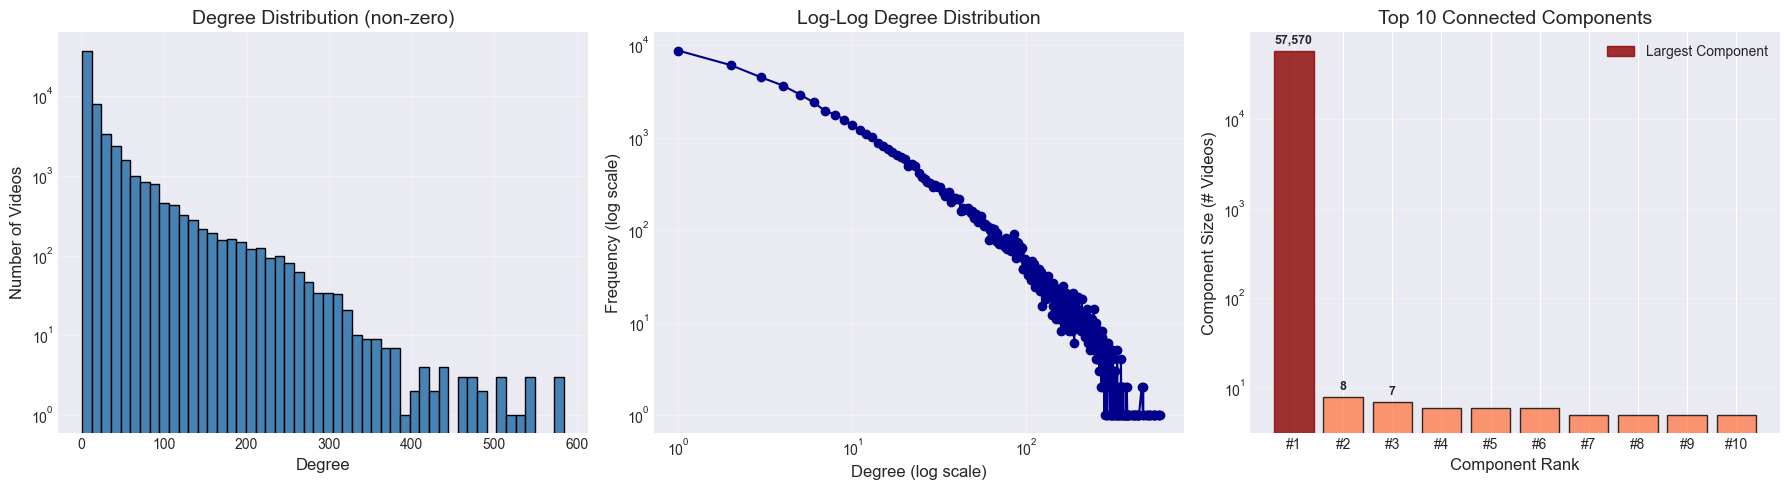

✓ Saved: data/network_degree_distribution.png


'data/network_degree_distribution.png'

In [37]:
# Plot degree distribution, log-log plot, and component sizes
visualization.plot_degree_distribution(G, output_dir='data', verbose=True)


## 5.2 Hub Video Ego Networks

Visualize the immediate neighborhood of the top hub videos to understand their local network structure.



Visualizing ego networks of top 3 hub videos...

Generating ego network for hub: FCjiMVHbXlQ (degree: 584)


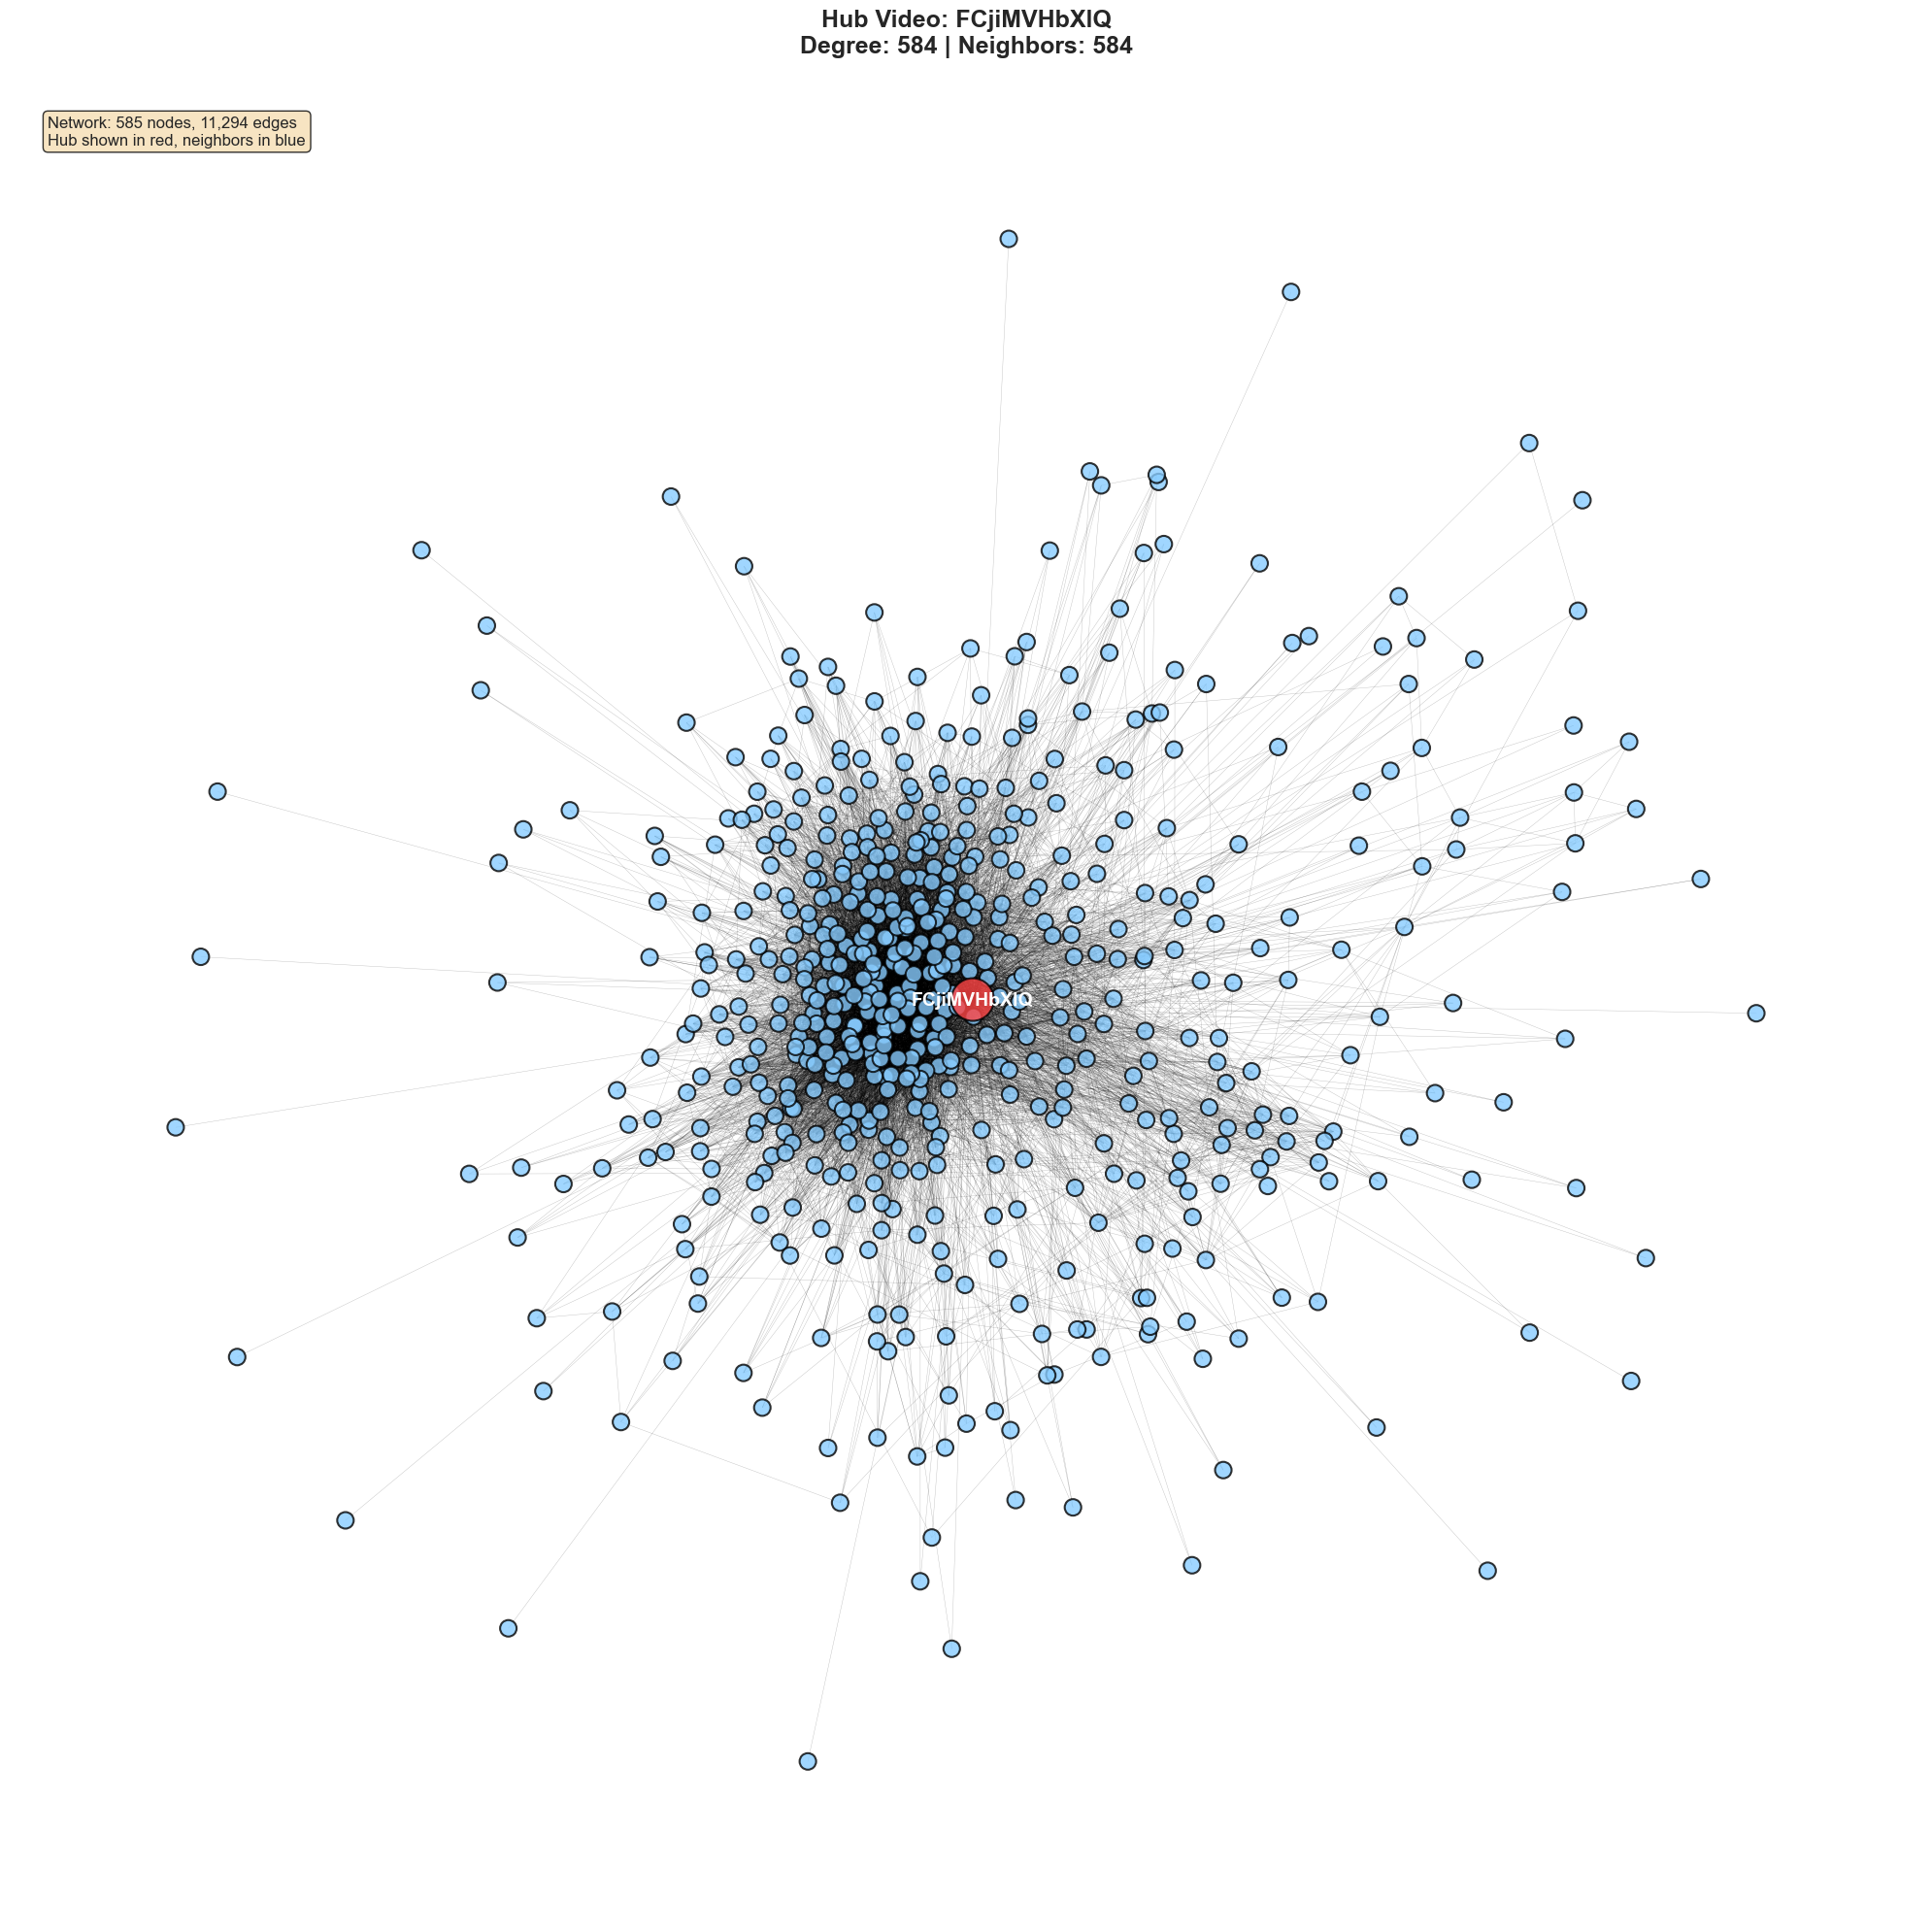

✓ Saved: data/network_hub_1_FCjiMVHbXlQ.png

Generating ego network for hub: NsrEb1aJxMY (degree: 580)


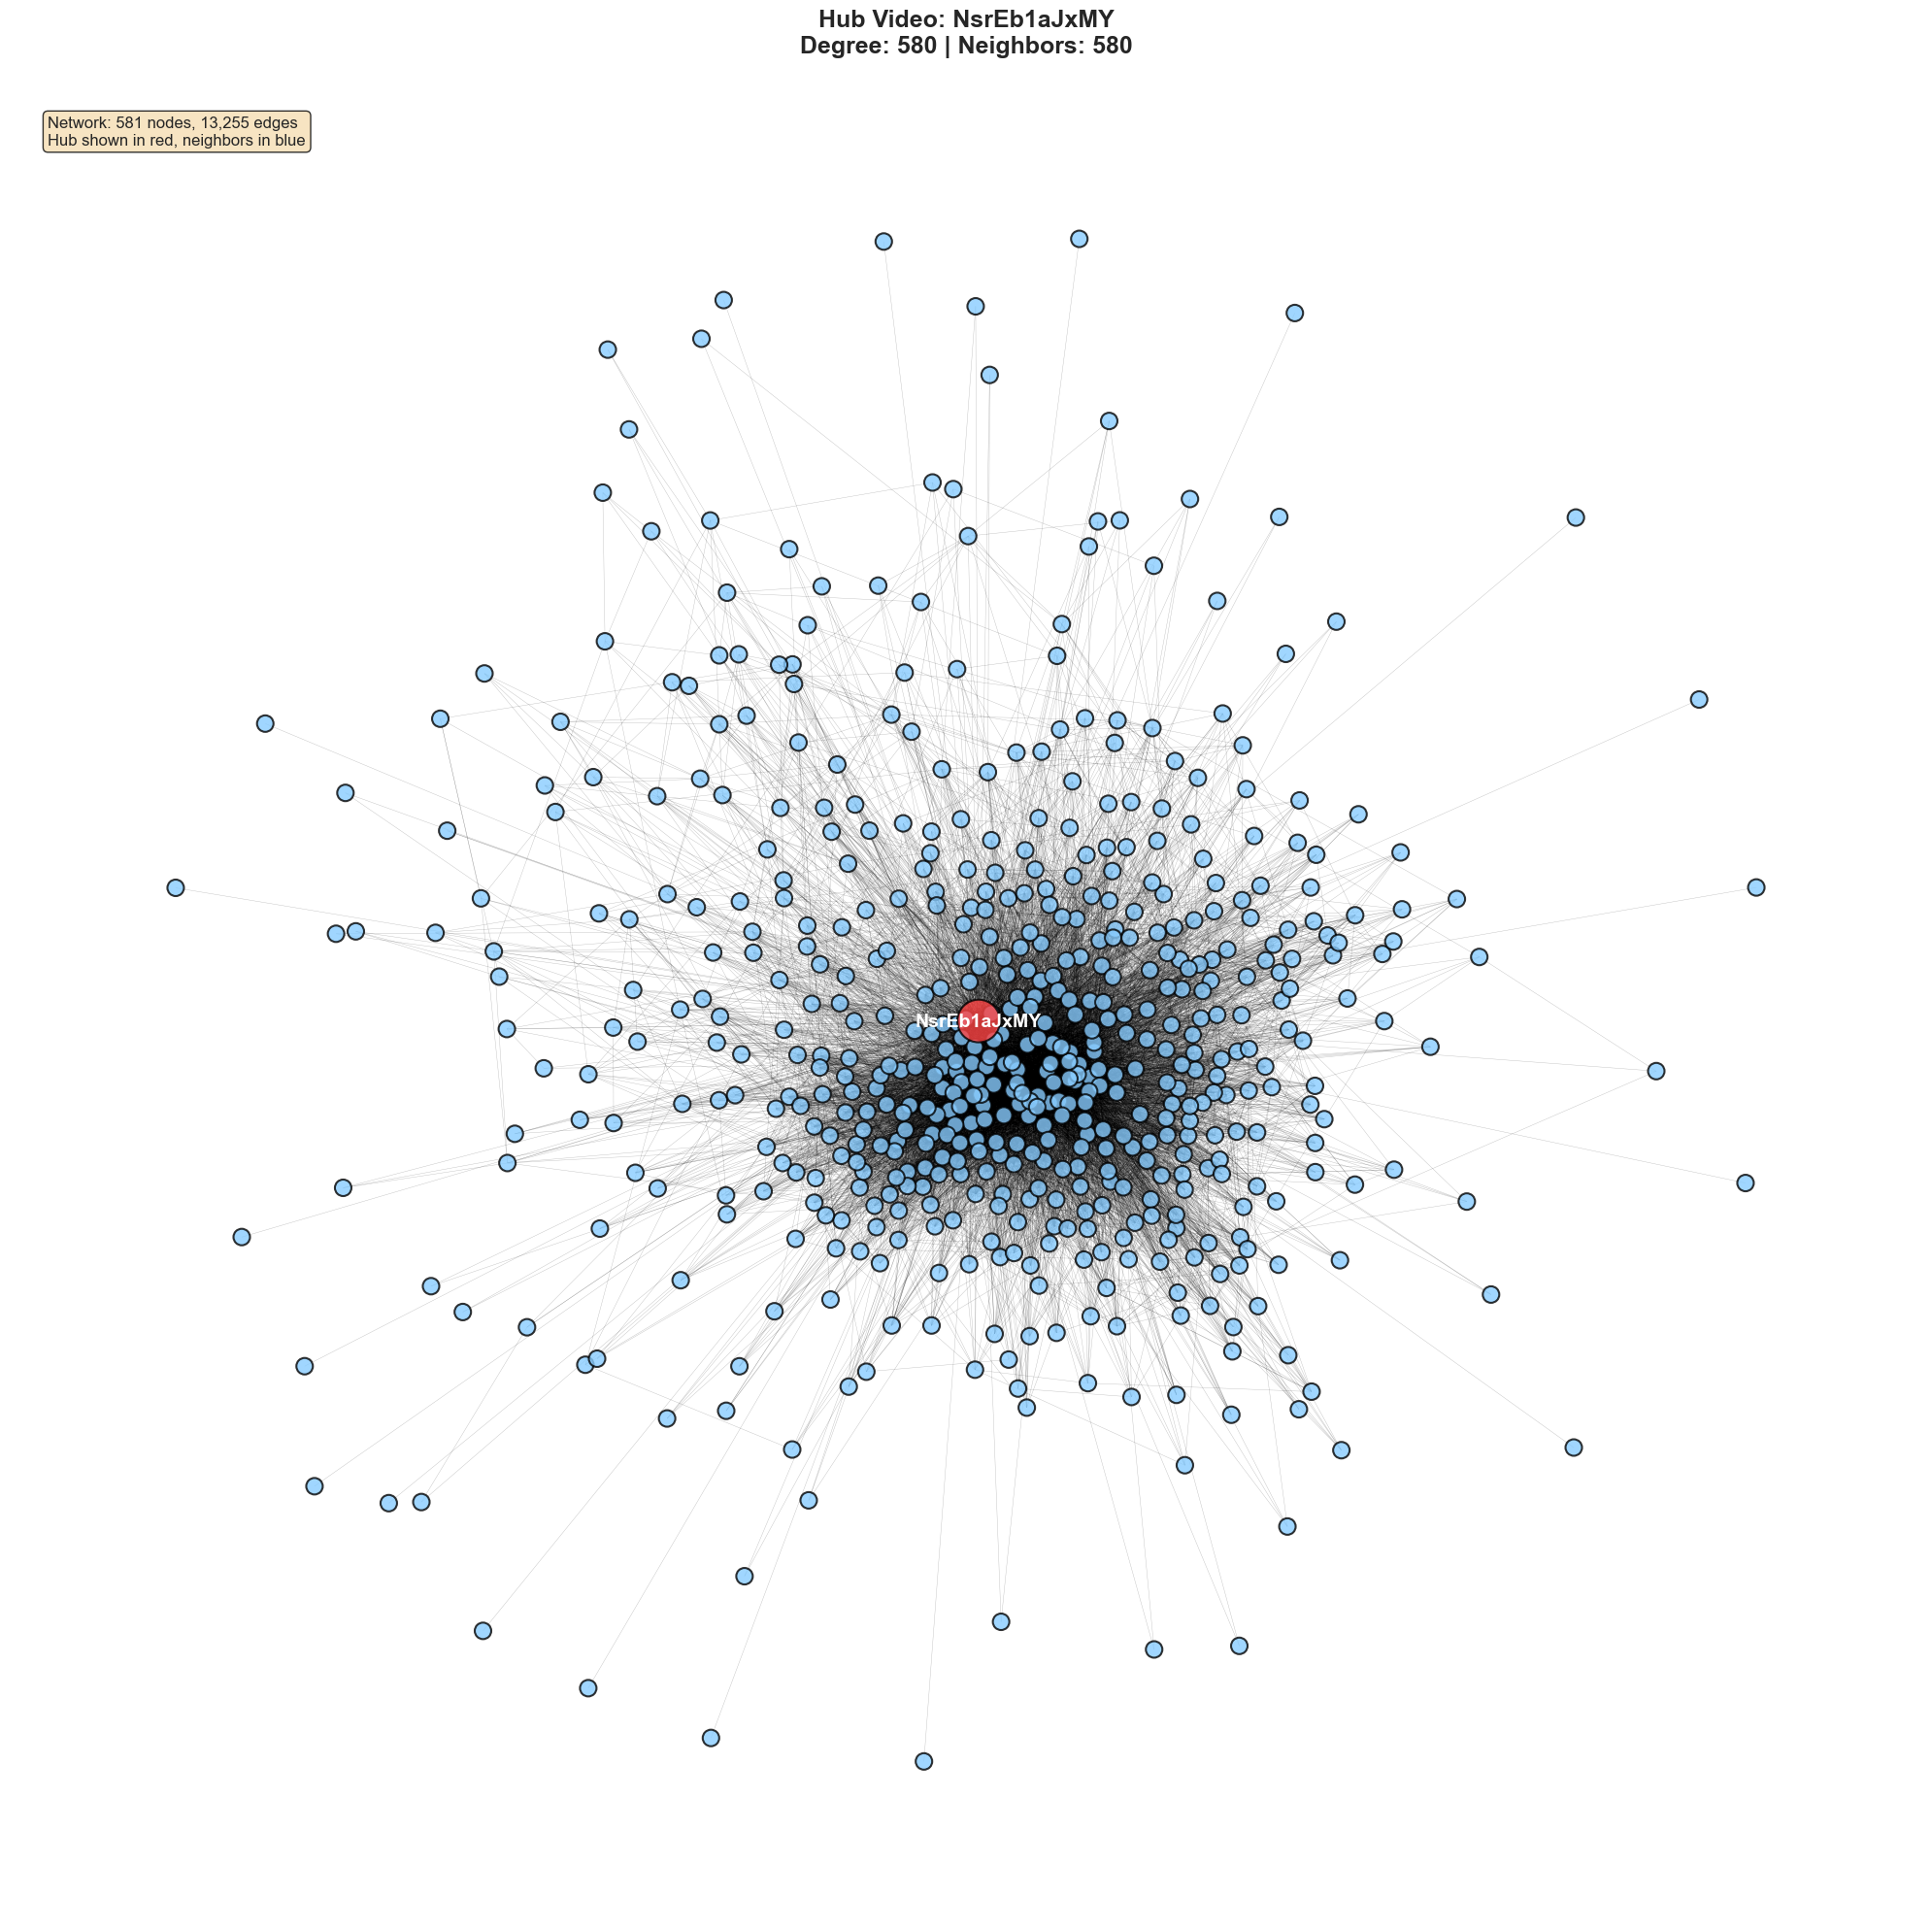

✓ Saved: data/network_hub_2_NsrEb1aJxMY.png

Generating ego network for hub: 8xFtIsyRvNE (degree: 573)


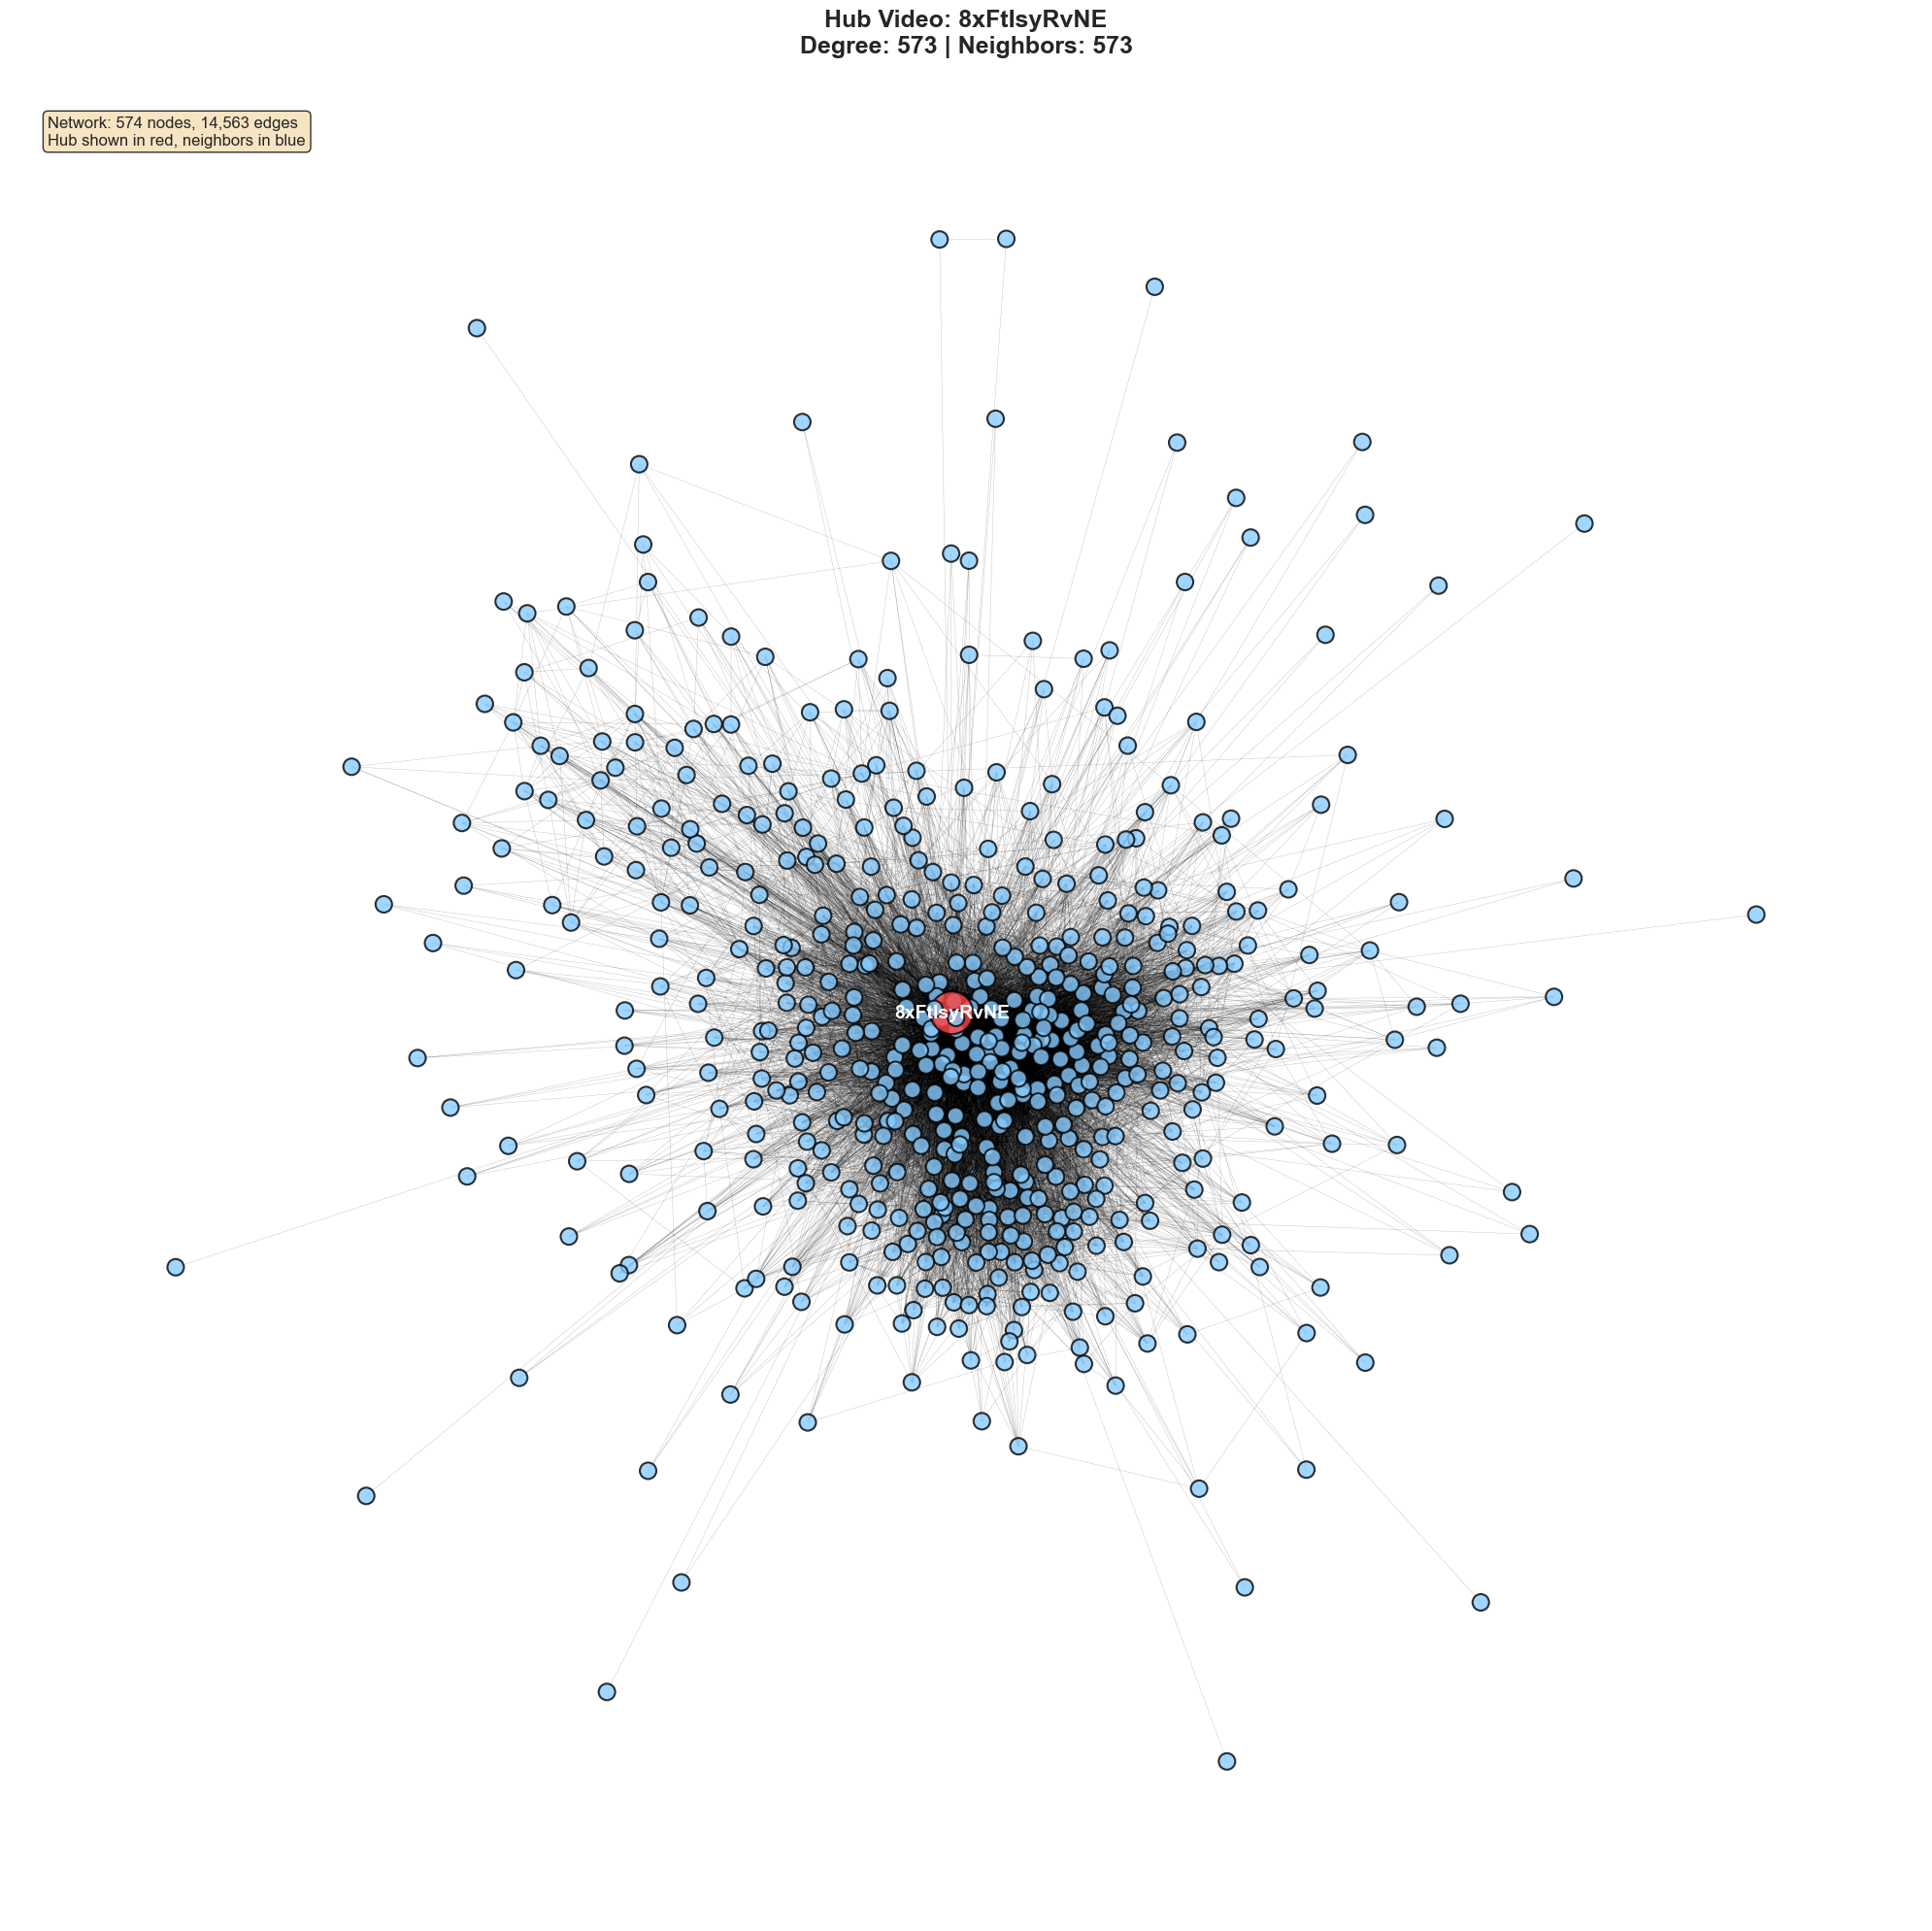

✓ Saved: data/network_hub_3_8xFtIsyRvNE.png

Creating combined overview...


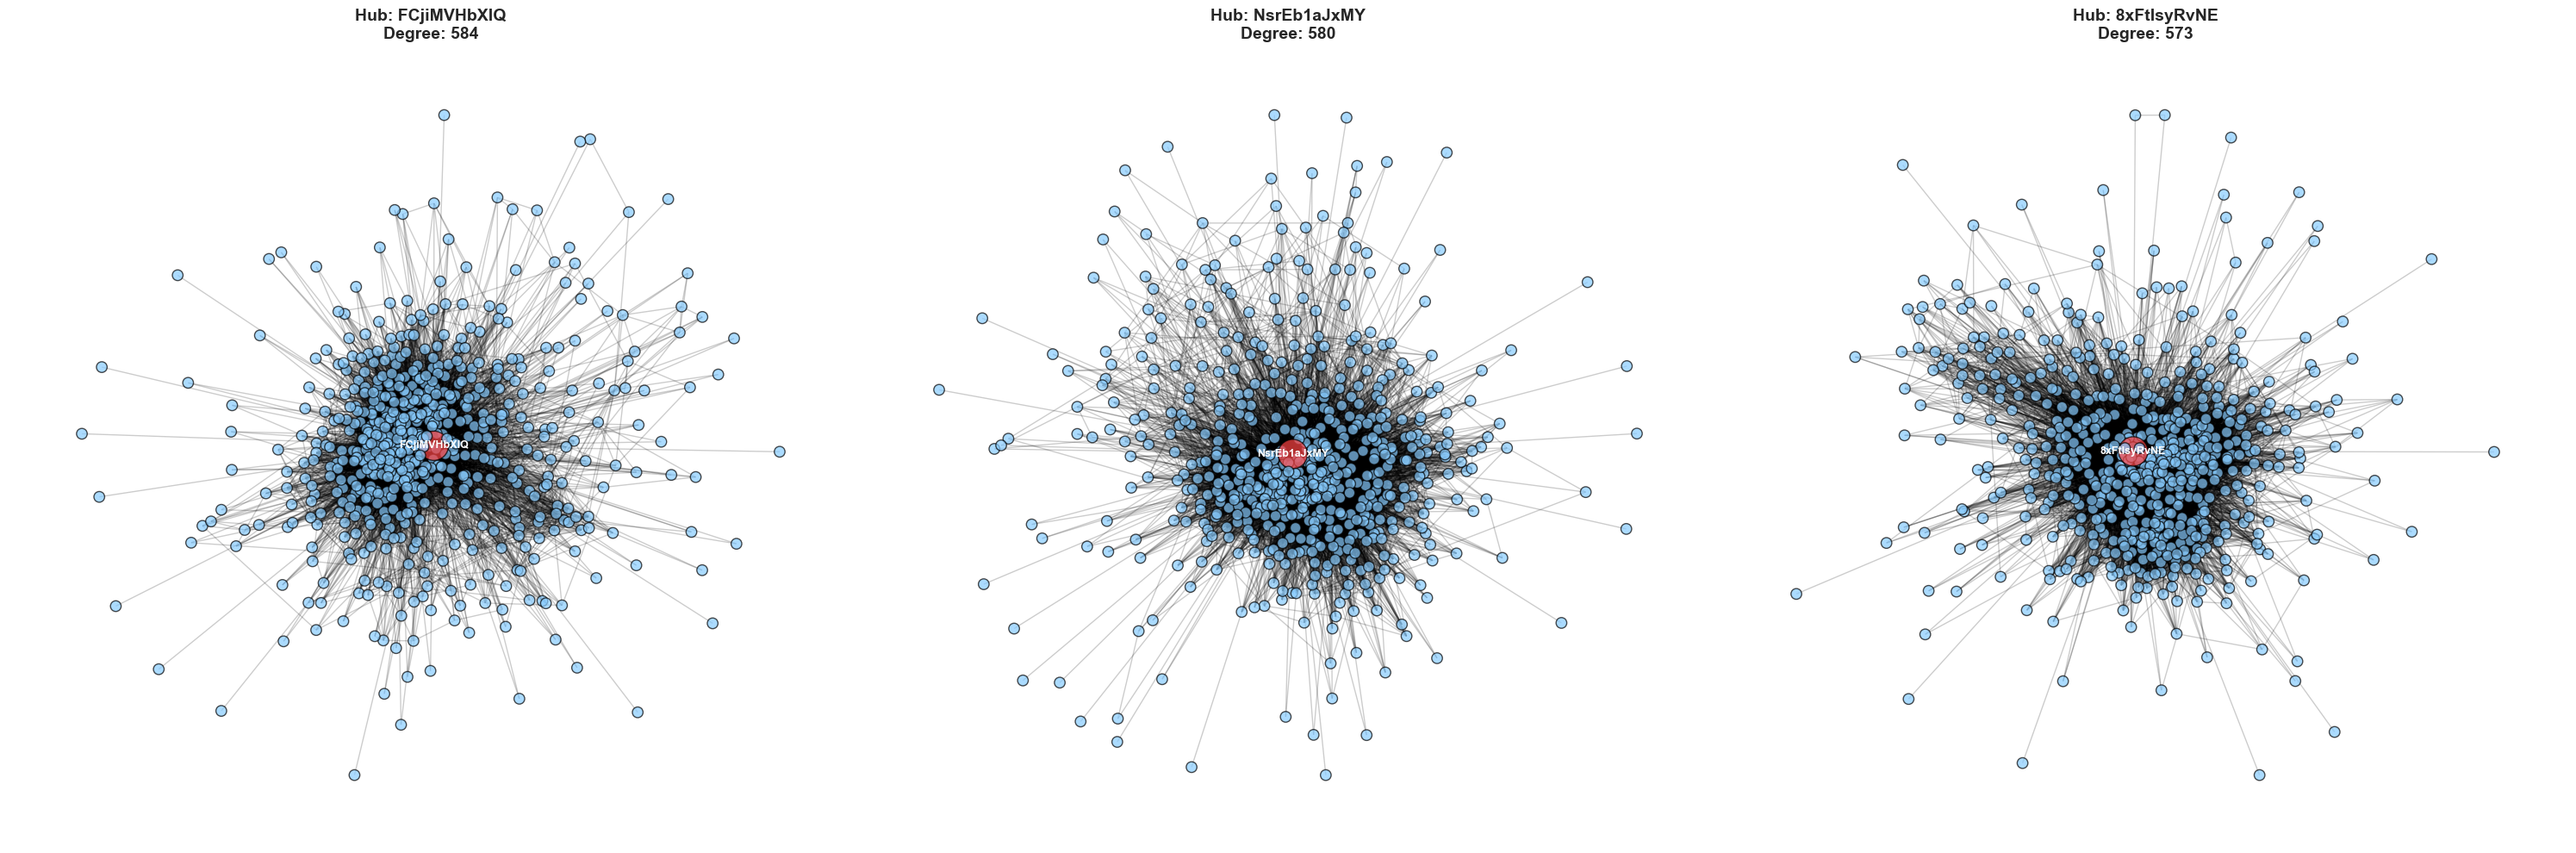

✓ Saved: data/network_hub_videos_overview.png

Top 3 Hub Videos:
  FCjiMVHbXlQ                              → Degree: 584
  NsrEb1aJxMY                              → Degree: 580
  8xFtIsyRvNE                              → Degree: 573


['data/network_hub_1_FCjiMVHbXlQ.png',
 'data/network_hub_2_NsrEb1aJxMY.png',
 'data/network_hub_3_8xFtIsyRvNE.png',
 'data/network_hub_videos_overview.png']

In [11]:
# Visualize ego networks for top 3 hub videos
# Creates individual large plots + combined overview
visualization.plot_top_hubs_ego_networks(G, top_n=3, output_dir='data', verbose=True)

# 6. Video Metadata Enrichment

Load video and channel metadata to enrich the network analysis with video titles, channels, and view counts.


## 6.1 Load Metadata

Load channel information and video metadata for the top hub videos.


In [28]:
# Step 1: Load channel data (small file, loads fast)
channels_path = '/Users/albertfares/Desktop/4650046/df_channels_en.tsv'
channels = data_loader.load_channel_data(channels_path, verbose=True)

# Step 2: Get the list of video IDs you actually need
degrees = dict(G.degree())
top_by_degree = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:20]
top_by_betweenness = sorted(betw.items(), key=lambda x: x[1], reverse=True)[:10] if betw else []

# Combine all video IDs you need metadata for
video_ids_needed = set()
video_ids_needed.update([vid for vid, _ in top_by_degree])
video_ids_needed.update([vid for vid, _ in top_by_betweenness])

print(f"\nNeed metadata for {len(video_ids_needed)} videos (vs. loading 50GB!)")

# Step 3: Use the efficient loader with channel mapping
metadata_path = '/Users/albertfares/Desktop/4650046/yt_metadata_en.jsonl'
video_metadata = data_loader.load_metadata_for_videos(
    metadata_path, 
    video_ids_needed,
    channel_map=channels,  # Pass channel data for name lookup
    verbose=True
)

Loading channel data from /Users/albertfares/Desktop/4650046/df_channels_en.tsv...
✓ Loaded 136,470 channels

Need metadata for 30 videos (vs. loading 50GB!)

Searching for metadata for 30 videos...
Scanning: /Users/albertfares/Desktop/4650046/yt_metadata_en.jsonl


Scanning metadata: 0 lines [00:00, ? lines/s]

✓ All 30 videos found! Stopping scan.

✓ Found metadata for 30/30 videos


## 6.2 Top Hub Videos (by Degree)

Display the top 20 videos ranked by network degree (number of connections to other videos).


In [29]:
# Display top hub videos with formatted output
print("="*80)
print("TOP HUB VIDEOS (By Network Degree)")
print("="*80)

top_hubs = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:20]

for rank, (video_id, degree) in enumerate(top_hubs, 1):
    if degree == 0:
        continue
    
    # Look up metadata
    meta = video_metadata.get(video_id, {})
    title = meta.get('title', 'Metadata not found')
    channel = meta.get('channel', 'Unknown')
    views = meta.get('views_formatted', '0')  # ← Use formatted views!
    
    print(f"\n{rank}. Video ID: {video_id}")
    print(f"   Title: {title[:80]}")
    print(f"   Channel: {channel}")  # ← Now shows name, not ID!
    print(f"   Views: {views}")  # ← Now shows "16.8M" instead of "16879028.0"
    print(f"   Network Degree: {degree} (shares commenters with {degree} videos)")
    print(f"   URL: https://www.youtube.com/watch?v={video_id}")
    print(f"   {'-'*78}")

TOP HUB VIDEOS (By Network Degree)

1. Video ID: FCjiMVHbXlQ
   Title: Harlem Shake FAIL
   Channel: PewDiePie
   Views: 24.3M
   Network Degree: 584 (shares commenters with 584 videos)
   URL: https://www.youtube.com/watch?v=FCjiMVHbXlQ
   ------------------------------------------------------------------------------

2. Video ID: NsrEb1aJxMY
   Title: $10 Million Celebrity Mansion for a Day
   Channel: shane
   Views: 18.0M
   Network Degree: 580 (shares commenters with 580 videos)
   URL: https://www.youtube.com/watch?v=NsrEb1aJxMY
   ------------------------------------------------------------------------------

3. Video ID: 8xFtIsyRvNE
   Title: The Truth About Tanacon
   Channel: shane
   Views: 22.7M
   Network Degree: 573 (shares commenters with 573 videos)
   URL: https://www.youtube.com/watch?v=8xFtIsyRvNE
   ------------------------------------------------------------------------------

4. Video ID: 9q2PgfYbppY
   Title: The Secret Life of Jeffree Star
   Channel: shane
   V

### Visualization

Create a horizontal bar chart showing the top 20 hub videos, color-coded by channel.


Generating top 20 videos visualization...


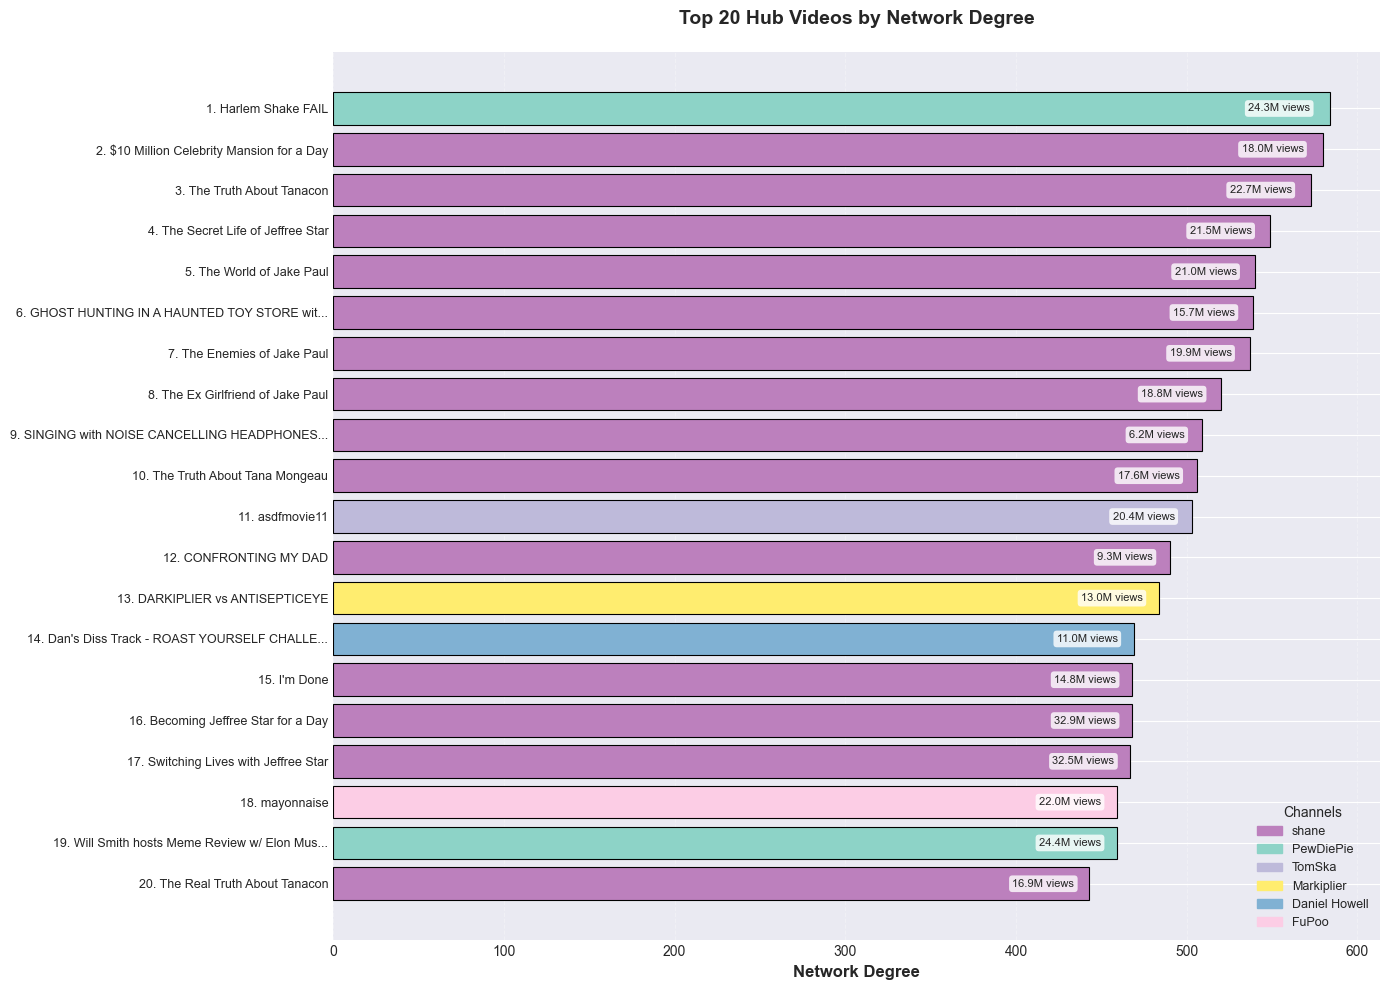

✓ Saved: data/top_hub_videos_degree.png
  Top channel: shane (14 videos)


'data/top_hub_videos_degree.png'

In [34]:
# Visualize top hub videos (by degree)
visualization.plot_top_videos(
    G, 
    video_metadata,
    top_n=20,
    metric='degree',
    output_dir='data',
    filename='top_hub_videos_degree.png',
    figsize=(14, 10),
    verbose=True
)

## 6.3 Top Pathway Videos (by Betweenness Centrality)

Display the top 10 videos ranked by betweenness centrality, showing videos that bridge different communities.


In [33]:
# If you computed betweenness, show top videos by betweenness too
if 'betw' in locals() and betw:
    print("\n" + "="*80)
    print("TOP PATHWAY VIDEOS (Highest Betweenness Centrality)")
    print("="*80)
    print("These videos act as bridges between different communities\n")
    
    top_betweenness = sorted(betw.items(), key=lambda x: x[1], reverse=True)[:10]
    
    for rank, (video_id, betw_score) in enumerate(top_betweenness, 1):
        if betw_score == 0:
            continue
        
        # Look up metadata
        meta = video_metadata.get(video_id, {})
        title = meta.get('title', 'Metadata not found')
        channel = meta.get('channel', 'Unknown')
        degree_val = degrees.get(video_id, 0)
        views = meta.get('views_formatted', '0')  # ← Use formatted views!
        
        print(f"{rank}. Video ID: {video_id}")
        print(f"   Title: {title[:80]}")
        print(f"   Channel: {channel}")
        print(f"   Views: {views}")  # ← Now shows "16.8M" instead of "16879028.0"
        print(f"   Betweenness: {betw_score:.6f}")
        print(f"   Degree: {degree_val}")
        print(f"   URL: https://www.youtube.com/watch?v={video_id}")
        print(f"   {'-'*78}\n")



TOP PATHWAY VIDEOS (Highest Betweenness Centrality)
These videos act as bridges between different communities

1. Video ID: 2QBsDH72MoM
   Title: Bye Pewdiepie | Carryminati
   Channel: CarryMinati
   Views: 25.3M
   Betweenness: 0.015684
   Degree: 139
   URL: https://www.youtube.com/watch?v=2QBsDH72MoM
   ------------------------------------------------------------------------------

2. Video ID: QKkHAIEjv2s
   Title: REACTING TO PEWDIEPIE & RICEGUM'S ROASTS ON MY BROTHER!
   Channel: Logan Paul Vlogs
   Views: 17.5M
   Betweenness: 0.014503
   Degree: 324
   URL: https://www.youtube.com/watch?v=QKkHAIEjv2s
   ------------------------------------------------------------------------------

3. Video ID: -iRXMxqcPrw
   Title: March of the Guitars - Joe Penna
   Channel: Joe Penna / MysteryG...
   Views: 2.3M
   Betweenness: 0.014352
   Degree: 73
   URL: https://www.youtube.com/watch?v=-iRXMxqcPrw
   ------------------------------------------------------------------------------

4. Vid

### Visualization

Create a horizontal bar chart showing the top 10 pathway videos, color-coded by channel.



Generating top 10 videos visualization...


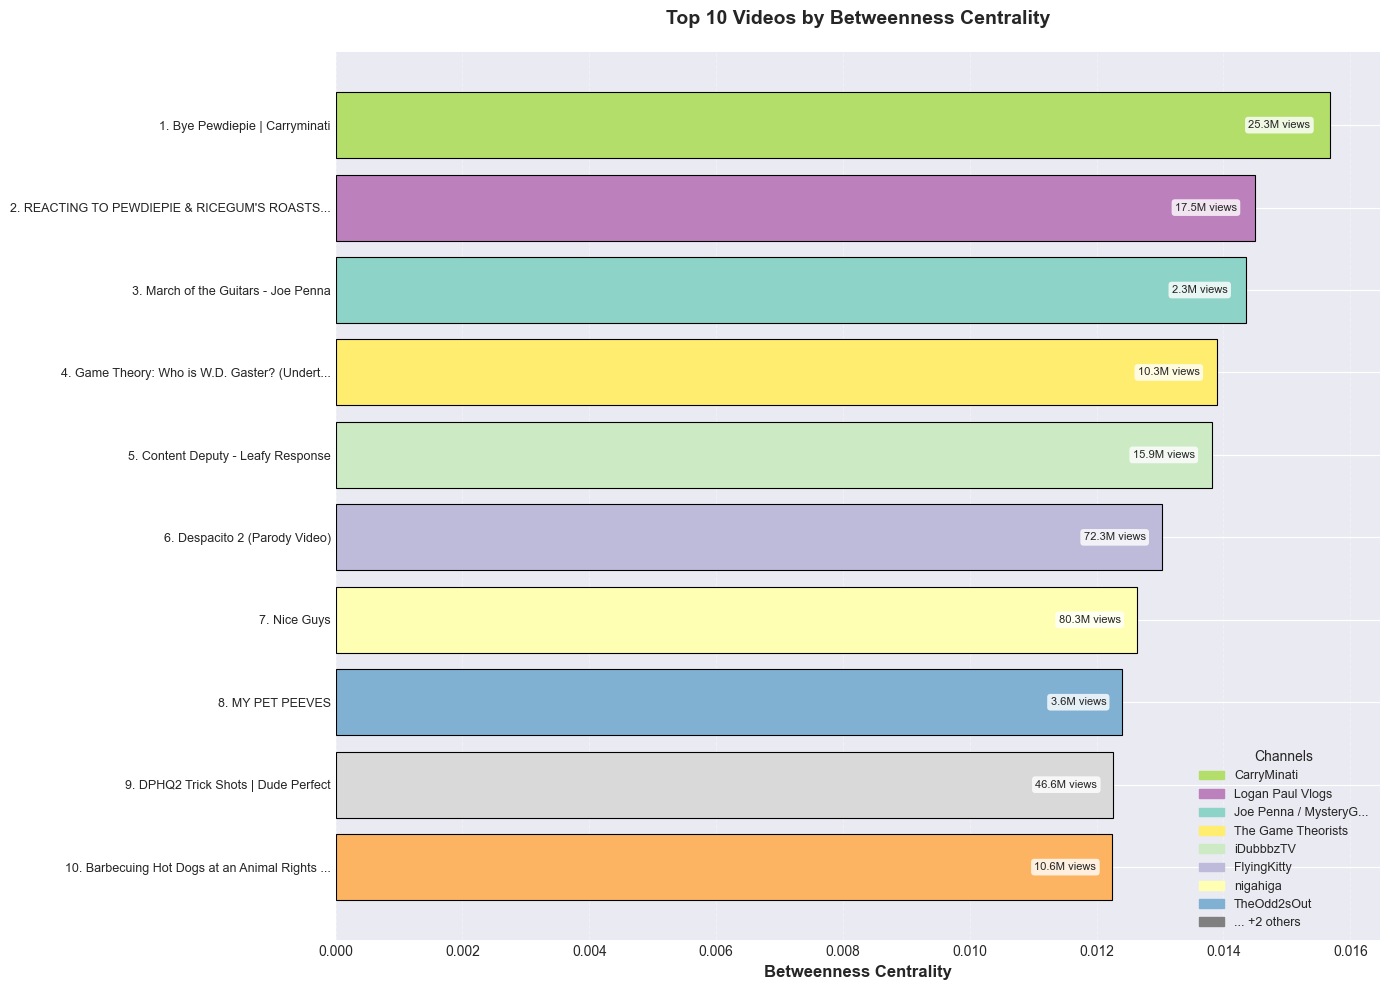

✓ Saved: data/top_hub_videos_betweenness.png
  Top channel: CarryMinati (1 videos)


'data/top_hub_videos_betweenness.png'

In [36]:
# Visualize top pathway videos (by betweenness)
visualization.plot_top_videos(
    G, 
    video_metadata,
    top_n=10,
    metric=betw,  # Pass the betweenness dict
    output_dir='data',
    filename='top_hub_videos_betweenness.png',
    figsize=(14, 10),
    verbose=True
)

# User Communities

# First approach

In [ ]:
comments   = pd.read_csv("/Users/matteo/Desktop/youniverse/processed/verysmall.tsv.gz", sep="\t", compression="gzip")
channels   = pd.read_csv("/Users/matteo/Desktop/youniverse/processed/df_channels_en.tsv.gz", sep="\t", compression="gzip")
timeseries = pd.read_csv("/Users/matteo/Desktop/youniverse/processed/df_timeseries_en.tsv.gz", sep="\t", compression="gzip")

ts_agg = timeseries.groupby('channel').agg({
    'delta_views': 'mean',
    'delta_subs': 'mean',
    'delta_videos': 'mean',
    'activity': 'mean'
}).reset_index()


channels = channels.merge(ts_agg, left_on='channel', right_on='channel', how='left')

merged = comments.merge(
    channels,
    left_on="name_cc",  
    right_on="name_cc",
    how="left"
)

merged['log_subs'] = np.log1p(merged['subscribers_cc'])
merged['join_year'] = pd.to_datetime(merged['join_date'], errors='coerce').dt.year

top_categories = merged['category_cc'].value_counts().nlargest(10).index.tolist()

def user_features(g):
    total_comments = g['num_comments'].sum()
    n_channels = g['name_cc'].nunique()
    weights = g['num_comments'] / total_comments

    f = {}
    # Activity
    f['total_comments'] = total_comments
    f['n_channels'] = n_channels
    f['avg_comments_per_channel'] = total_comments / n_channels if n_channels else 0

    # Diversity
    cat_counts = g.groupby('category_cc')['num_comments'].sum()
    p = cat_counts / cat_counts.sum()
    f['category_entropy'] = -(p * np.log(p)).sum()
    f['num_unique_categories'] = len(p)

    # Category profile (top10)
    for c in top_categories:
        f[f'cat_{c}'] = p.get(c, 0)

    # Channel size
    f['mean_log_subs'] = np.average(g['log_subs'], weights=weights)
    f['std_log_subs'] = np.sqrt(np.cov(g['log_subs'], aweights=weights)) if len(g) > 1 else 0

    # Channel age
    if g['join_year'].notna().any():
        yrs = g['join_year'].dropna()
        w = weights.loc[yrs.index]
        f['mean_join_year'] = np.average(yrs, weights=w)
        f['std_join_year'] = np.sqrt(np.cov(yrs, aweights=w)) if len(yrs) > 1 else 0
    else:
        f['mean_join_year'] = f['std_join_year'] = np.nan

    # Upload activity
    for col in ['delta_videos', 'activity']:
        if col in g:
            f[f'mean_{col}'] = np.average(g[col].fillna(0), weights=weights)
        else:
            f[f'mean_{col}'] = np.nan

    # Channel growth
    for col in ['delta_subs', 'delta_views']:
        if col in g:
            f[f'mean_{col}'] = np.average(g[col].fillna(0), weights=weights)
        else:
            f[f'mean_{col}'] = np.nan

    return pd.Series(f)

user_features_df = merged.groupby('author', group_keys=False).apply(user_features).fillna(0).reset_index()

output_path = "user_vectors.csv" 
user_features_df.to_csv(output_path, index=False)

print(f"Wrote {len(user_features_df):,} user vectors to {output_path}")
print("Columns:", list(user_features_df.columns))
print(user_features_df.head())

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("user_vectors.csv")

user_ids = df["author"]
X = df.drop(columns=["author"])

#standardize 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#reduce dim for visualization
pca_2d = PCA(n_components=2, random_state=0)
X_2d = pca_2d.fit_transform(X_scaled)

#for clustering stability
pca_10 = PCA(n_components=10, random_state=0)
X_10d = pca_10.fit_transform(X_scaled)

print(f"Explained variance (10 comps): {pca_10.explained_variance_ratio_.sum():.2f}")

# actual clustering (8-KNN here) 
# TODO: more techniques
kmeans = KMeans(n_clusters=8, random_state=0, n_init="auto")
labels = kmeans.fit_predict(X_10d)

df["cluster"] = labels

#visualisation 
plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap="tab10", s=10, alpha=0.7)
plt.title("User clusters (PCA 2D projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

summary = (
    df.groupby("cluster")[X.columns]
      .mean()
      .round(2)
      .sort_index()
)

cluster_output_path = "cluster_output.txt"

with open(cluster_output_path, "w") as f:
    f.write("=== Cluster Feature Means ===\n")
    f.write(summary.to_string())
    f.write("\n\n=== Silhouette Scores ===\n")

    print("=== Cluster Feature Means ===")
    print(summary)
    print("\n=== Silhouette Scores ===")

    for k in range(4, 12):
        labels = KMeans(n_clusters=k, random_state=0, n_init="auto").fit_predict(X_10d)
        score = silhouette_score(X_10d, labels)
        line = f"k={k}, silhouette={score:.3f}"
        print(line)
        f.write(line + "\n")

print(f"\nResults written to {cluster_output_path}")


# Second approach

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import community as community_louvain

In [ ]:
# Load data
df_l = pd.read_csv("../Dataset/custom/author_namecc_comment_counts.tsv.gz",
                 sep="\t", compression="infer",
                 dtype={"author":"string","channel":"string","num_comments":"int"})

print(f"Loaded {len(df_l)} rows.")

df_l = df_l.sort_values(by="num_comments", ascending=False)

In [ ]:
# Take a subset for testing
df = df_l.head(100000)

# Map authors and channels to indices
users = pd.Index(df["author"].unique(), name="author")
channels = pd.Index(df["name_cc"].unique(), name="name_cc")
u_idx = pd.Series(np.arange(len(users)), index=users)
c_idx = pd.Series(np.arange(len(channels)), index=channels)

# Build user–channel sparse matrix
rows = df["author"].map(u_idx).to_numpy()
cols = df["name_cc"].map(c_idx).to_numpy()
vals = np.ones_like(rows, dtype=np.float32)
X = coo_matrix((vals, (rows, cols)), shape=(len(users), len(channels))).tocsr()

# Use k-nn with cosine similarity to find similar users
k = 5  # number of neighbors
nn = NearestNeighbors(n_neighbors=min(k+1, X.shape[0]), metric="cosine", algorithm="brute", n_jobs=-1)
nn.fit(X)
distances, indices = nn.kneighbors(X, return_distance=True)

# Convert distances to similarities
sims = 1.0 - distances

# Build graph from k-nn results
G = nx.Graph()
G.add_nodes_from(range(X.shape[0]))  # nodes are user indices

# Add edges for similarities above threshold
sim_threshold = 0.8
for i in tqdm(range(indices.shape[0])):
    for j in range(1, indices.shape[1]):  # skip self at j=0
        v = int(indices[i, j])
        w = float(sims[i, j])
        if w >= sim_threshold:
            # to avoid duplicates, add edge with max weight
            if G.has_edge(i, v):
                if w > G[i][v]["weight"]:
                    G[i][v]["weight"] = w
            else:
                G.add_edge(i, v, weight=w)

print(f"Constructed graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Remove isolated nodes
isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)
print(f"Number of isolated users: {len(isolated)}")
print(f"After removing isolates: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Remove small components
n = 100  # min component size
small_comps = [comp for comp in nx.connected_components(G) if len(comp) < n]
G.remove_nodes_from(set().union(*small_comps))
G.remove_edges_from(nx.selfloop_edges(G))
print(f"Number of small components: {len(small_comps)}")
print(f"After removing small components: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Louvain community detection
partition = community_louvain.best_partition(G, weight="weight")
nx.set_node_attributes(G, partition, "community")

# Visualize communities
pos = nx.spring_layout(G, seed=42, k=0.2)
colors = [partition[n] for n in G.nodes()]

# Plot
plt.figure(figsize=(70,60))
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=40,cmap=plt.cm.turbo, alpha=0.85)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("User communities (k-NN on cosine over channels)")
plt.axis("off")
plt.show()

Result: `data/user_level_part_2.png`